In [0]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano' # Why theano why not
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

In [0]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [0]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [74]:
# reading data
df = pd.read_excel('dataset.xlsx')
df = df.dropna()
df = df.reset_index(drop=True)
print('Shape of dataset ',df.shape)
print(df.columns)
print('No. of unique classes',len(set(df['class'])))

Shape of dataset  (100, 2)
Index(['message', 'class'], dtype='object')
No. of unique classes 17


In [0]:
macronum=sorted(set(df['class']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

df['class']=df['class'].apply(fun)

In [76]:
texts = []
labels = []


for idx in range(df.message.shape[0]):
    text = BeautifulSoup(df.message[idx])
    texts.append(clean_str(str(text.get_text().encode())))

for idx in df['class']:
    labels.append(idx)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))


In [77]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 932


In [78]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Shape of Data Tensor: (100, 1000)
Shape of Label Tensor: (100, 17)


In [79]:
embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [0]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

In [80]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(len(macronum), activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Simplified convolutional neural network")
model.summary()
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Simplified convolutional neural network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         93300     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 199, 128)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 39, 128)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 

In [62]:
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=15, batch_size=2,callbacks=[cp])

Train on 80 samples, validate on 20 samples
Epoch 1/15
80/80 [==============================] - 4s 49ms/step - loss: 2.6623 - acc: 0.2500 - val_loss: 2.3584 - val_acc: 0.2500

Epoch 00001: val_acc improved from -inf to 0.25000, saving model to model_cnn.hdf5
Epoch 2/15
80/80 [==============================] - 4s 50ms/step - loss: 1.9873 - acc: 0.4375 - val_loss: 1.8733 - val_acc: 0.4500

Epoch 00002: val_acc improved from 0.25000 to 0.45000, saving model to model_cnn.hdf5
Epoch 3/15
80/80 [==============================] - 4s 50ms/step - loss: 1.2715 - acc: 0.6625 - val_loss: 1.4019 - val_acc: 0.6500

Epoch 00003: val_acc improved from 0.45000 to 0.65000, saving model to model_cnn.hdf5
Epoch 4/15
80/80 [==============================] - 4s 49ms/step - loss: 0.9800 - acc: 0.7250 - val_loss: 1.5273 - val_acc: 0.6500

Epoch 00004: val_acc did not improve from 0.65000
Epoch 5/15
54/80 [===================>..........] - ETA: 1s - loss: 0.7271 - acc: 0.8333

80/80 [==============================] - 4s 50ms/step - loss: 0.7497 - acc: 0.8250 - val_loss: 1.1414 - val_acc: 0.6500

Epoch 00005: val_acc did not improve from 0.65000
Epoch 6/15
80/80 [==============================] - 4s 49ms/step - loss: 0.6599 - acc: 0.8500 - val_loss: 1.2248 - val_acc: 0.6500

Epoch 00006: val_acc did not improve from 0.65000
Epoch 7/15
80/80 [==============================] - 4s 50ms/step - loss: 0.5452 - acc: 0.8875 - val_loss: 1.1178 - val_acc: 0.7000

Epoch 00007: val_acc improved from 0.65000 to 0.70000, saving model to model_cnn.hdf5
Epoch 8/15
80/80 [==============================] - 4s 49ms/step - loss: 0.4755 - acc: 0.8625 - val_loss: 1.0355 - val_acc: 0.7500

Epoch 00008: val_acc improved from 0.70000 to 0.75000, saving model to model_cnn.hdf5
Epoch 9/15
80/80 [==============================] - 4s 49ms/step - loss: 0.4063 - acc: 0.8750 - val_loss: 1.3590 - val_acc: 0.7000

Epoch 00009: val_acc did not improve from 0.75000
Epoch 10/15
16/80 [=====>....

80/80 [==============================] - 4s 49ms/step - loss: 0.4028 - acc: 0.9250 - val_loss: 1.2219 - val_acc: 0.8000

Epoch 00010: val_acc improved from 0.75000 to 0.80000, saving model to model_cnn.hdf5
Epoch 11/15
80/80 [==============================] - 4s 49ms/step - loss: 0.4737 - acc: 0.8875 - val_loss: 1.1734 - val_acc: 0.8000

Epoch 00011: val_acc did not improve from 0.80000
Epoch 12/15
80/80 [==============================] - 4s 49ms/step - loss: 0.2344 - acc: 0.9250 - val_loss: 1.3924 - val_acc: 0.8000

Epoch 00012: val_acc did not improve from 0.80000
Epoch 13/15
80/80 [==============================] - 4s 50ms/step - loss: 0.1823 - acc: 0.9750 - val_loss: 1.7238 - val_acc: 0.8000

Epoch 00013: val_acc did not improve from 0.80000
Epoch 14/15
80/80 [==============================] - 4s 49ms/step - loss: 0.4431 - acc: 0.9375 - val_loss: 1.4792 - val_acc: 0.8000

Epoch 00014: val_acc did not improve from 0.80000
Epoch 15/15
10/80 [==>...........................] - ETA: 3s 

80/80 [==============================] - 4s 49ms/step - loss: 0.1814 - acc: 0.9250 - val_loss: 1.5112 - val_acc: 0.8000

Epoch 00015: val_acc did not improve from 0.80000


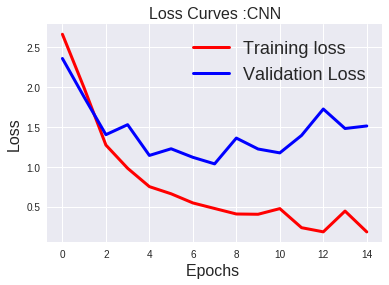

In [63]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

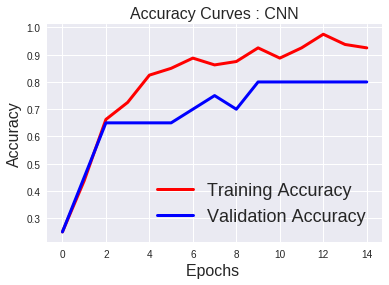

In [64]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

In [0]:
#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

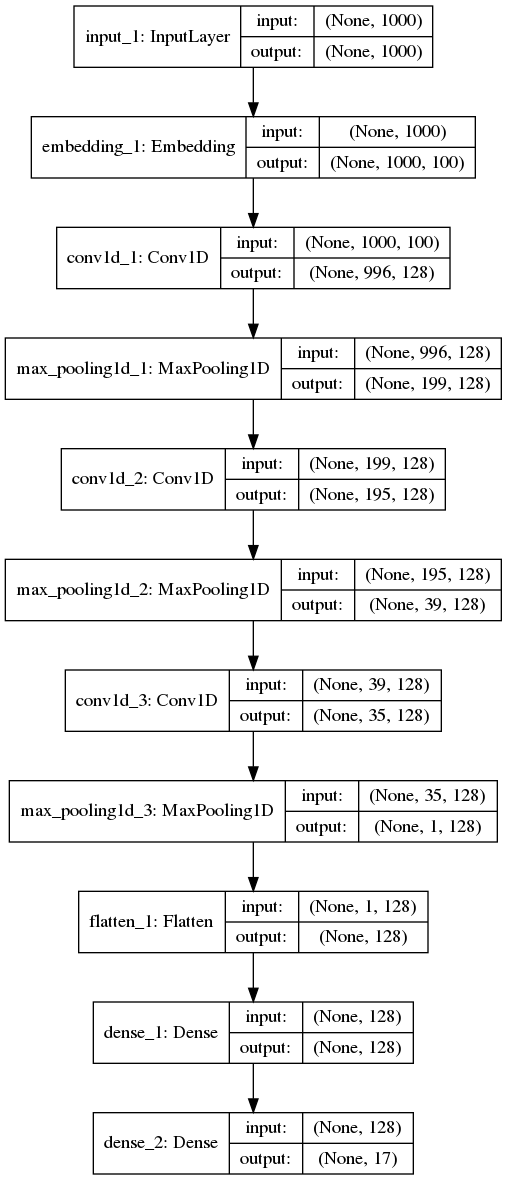

In [105]:
from PIL import Image
display(Image.open('cnn_model.png'))